<a href="https://colab.research.google.com/github/DiGyt/neuropynamics/blob/master/notebooks/pplane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ! pip3 install sympy, matplotlib, numpy, scipy, ipywidgets

In [ ]:
from sympy import symbols, solve, lambdify, sympify, dsolve, Eq, solveset, linear_eq_to_matrix, nonlinsolve, Matrix, diff, sqrt
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import quiver
from scipy import integrate

from ipywidgets import widgets
from IPython.display import clear_output, display, HTML

In [ ]:
def rk4( f, x0, y0, h, xn ):
    n = int((xn - x0)/h)
    x = np.array( [ x0 ] * n, dtype=float )
    y = np.array( [ y0 ] * n, dtype=float )
    for i in range( n-1 ):
        k1 = h * f( x[i], y[i] )
        k2 = h * f( x[i] + 0.5 * h, y[i] + 0.5 * k1 )
        k3 = h * f( x[i] + 0.5 * h, y[i] + 0.5 * k2 )
        k4 = h * f( x[i] + h, y[i] + k3 )
        
        x[i+1] = x[i] + h
        y[i+1] = y[i] + ( k1 + 2.0 * ( k2 + k3 ) + k4 ) / 6.0
        
    return y, x


In [ ]:
def plotEquation (eq, solvar, plotvar, inputrange):
    '''
        Given a sympy equation object `eq`, this function return a series of values,
        in the range of `inputrange` such that the equation is solved for
        `solvar` and the input is for `plotvar`
    '''
    eq = Eq(eq, 0)
    sol = solve(eq, solvar)
    vals = []
    for s in sol:
        f = lambdify((plotvar), sol)
        vals.append([f(i) for i in inputrange])

    return vals

In [ ]:
def findFixedPoints(f, g, xrange, yrange):
    return [(x, y) for x in xrange for y in yrange if f(x, y) == 0 and g(x, y) == 0]

In [ ]:
def system(initialx, initialy, func1, func2, delta, timerange):
    x = [initialx]
    y = [initialy]
    
    for i in range(timerange):
        x.append(x[i] + func1(x[i], y[i]) * delta)
        y.append(y[i] + func2(x[i], y[i]) * delta)
    
    return x, y

In [ ]:
def plots(expr1, expr2, x, y, startx, starty, stepsize, numsteps):
    '''
        expr1: sympy expression - non linear ode
        expr2: sympy expression - non linear ode
        x: sympy variable used in expr1 and/or expr2
        y: sympy variable used in expr1 and/or expr2
        startx: for the range-kutta4, the x variable needs a start value
        starty: for the range-kutta4, the y variable needs a start value
        stepsize: step size for runge-kutta4
        numsteps: the number of steps runge-kutta4 should take
    '''
    # converting the equations to functions
    f1 = lambdify((x, y), expr1)
    f2 = lambdify((x, y), expr2)
    
    # phase space
    sx, sy = system(startx, starty, f1, f2, stepsize, numsteps)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
    ax1.plot(sx, label='X in Time')
    ax1.plot(sy, label='Y in Time')
    ax2.plot(sx, sy, label='X against Y')
    ax1.legend()
    ax2.legend()
    
    # compute ranges to work in
    yrange = np.linspace(y_range_slider.value[0], y_range_slider.value[1])
    xrange = np.linspace(x_range_slider.value[0], x_range_slider.value[1])
    
    # a plot for the quiver plot and nullclines
    fig, ax = plt.subplots(figsize=(20,20))
    ax.set_xlim([min(xrange), max(xrange)])
    ax.set_ylim([min(yrange), max(yrange)])
    
    # plotting the 4 nullclines from range-kutta4
    rkx, rky = rk4( f1, min(xrange), -1000, .25, max(xrange) )
    ax.scatter(rkx, rky, marker='+', label='Solution with Runge-Kutta 4', s=150)
    
    rky, rkx = rk4( f1, min(xrange), -1000, .25, max(xrange) )
    ax.scatter(rkx, rky, marker='+', label='Solution with Runge-Kutta 4', s=150)
    
    rkx, rky = rk4( f2, min(yrange), 0, .25, max(yrange) )
    ax.scatter(rkx, rky, marker='+', label='Solution with Runge-Kutta 4', s=150)
    
    rky, rkx = rk4( f2, min(yrange), 0, .25, max(yrange) )
    ax.scatter(rkx, rky, marker='+', label='Solution with Runge-Kutta 4', s=150)
    
    # compute quivers
    f1_val = [[f1(i, j) for i in xrange] for j in yrange];
    f2_val = [[f2(i, j) for i in xrange] for j in yrange];

    # plot quiver plot
    q = ax.quiver(xrange, yrange, f1_val, f2_val, alpha=.5)
    
    # solve analytically using sympy
    solutions = solve((Eq(expr1, 0), Eq(expr2, 0)), x, y)
    
    # compute jacobian and eigen values
    equationMatrix = Matrix([ expr1, expr2 ])
    varMat = Matrix([ x, y ])
    jacobian = equationMatrix.jacobian(varMat)
    display(HTML('''<h2>Jacobian Matrix</h2> <br /> The Jacobian matrix has single order derivatives
                    of a System of Equations.</h2>'''))
    display(jacobian)
    
    # display eigen values
    display(HTML('<br /> <br /> <br /> <h2>Eigen Values</h2> <br /> <img src="/src/2d-stability.png" />'))
    op = '''<table>
                     <th>
                         <td>Stable Point</td>
                         <td>Eigen Values</td>
                         <td>Type of Stability Point</td>
                     </th>'''
    for s in solutions:
        eqmat = jacobian.subs([ (x, s[0]), (y, s[1]) ])
        ev = list(eqmat.eigenvals().keys())
        
        if ev[0].is_real:
            if ev[0] > 0 and ev[1] > 0:
                t = 'Unstable Node'
            elif ev[0] < 0 and ev[1] < 0:
                t = 'Stable Node'
            elif (ev[0] < 0 and ev[1] > 0) or (ev[0] > 0 and ev[1] < 0):
                t = 'Saddle Point'
        else:
            if ev[0].args[0] > 0:
                t = 'Unstable Focus'
            if ev[0].args[0] < 0:
                t = 'Stable Focus'
        
        op = op + '''<tr>
                            <td>%s</td>
                            <td>%s, %s</td>
                            <td>%s</td>
                        </tr>''' % (str(s), ev[0], ev[1], t)
    op = op + '</table>'
    display(HTML(op))
    
    display(HTML('''<br /> <br /> <br /> <h2>Phase Potrait</h2> <br />
                 Phase Potrait shows the change in the two quantities with respect to each other
                 and idependantly.<br />'''))
    
    # plot the analytical solution
    try:
        [ax.plot(yrange, nc, c='b', alpha=.7, label='Analytical Solution') for nc in plotEquation(expr1, y, x, yrange)]
        [ax.plot(nc, yrange, c='b', alpha=.7, label='Analytical Solution') for nc in plotEquation(expr1, x, y, xrange)]
        [ax.plot(nc, xrange, c='r', alpha=.7, label='Analytical Solution') for nc in plotEquation(expr2, x, y, xrange)]
        [ax.plot(xrange, nc, c='r', alpha=.7, label='Analytical Solution') for nc in plotEquation(expr2, y, x, yrange)]
    except:
        print('Some nullcline values are complex')
    
    # plot the roots
    try:
        [ax.scatter(i[0], i[1], marker='x', label='Stable Point', s=150) for i in solutions]
    except:
        print('Some roots are complex')

    # a legend for our plot
    display(HTML('''<h2>Quiver Plot and Null Clines</h2><br />
                    A quiver plot shows the direction the system is moving in at each co-ordinate. <br />
                    Null Clines are lines where one of the two variables are zero. The Points 
                    where Null Clines intersect are where the system is stable because both variables are 
                    zero at that point.<br />
                    Null Clines can be obtained analytically (using calculus) and numerically.'''))
    fig.legend(framealpha=1, fancybox=True, fontsize='large', loc=1)
    fig.show()


# Specify your equation

In [ ]:
x, y = symbols('x y')

# expr1 = 2*x - y + 3*(x**2 - y**2) + 2*x*y
expr1 = 2*x - x**2 - x*y
# expr1 = 5 - y + 5
display(expr1)

# expr2 = x - 3*y - 3*(x**2-y**2) + 3*x*y
expr2 = -y + x*y
# expr2 = 3*(4*x-5*y)
display(expr2)

-x**2 - x*y + 2*x

x*y - y

# Select range of x and y values and click the plot button

In [ ]:
import sympy

In [ ]:
? sympy.Add.args

IntRangeSlider(value=(-5, 5), max=10, min=-10)

IntRangeSlider(value=(-5, 5), max=10, min=-10)

Button(description='Plot', style=ButtonStyle())

Matrix([
[-2*x - y + 2,    -x],
[           y, x - 1]])

"(0, 0)","2, -1",Saddle Point
"(1, 1)","-1/2 - sqrt(3)*I/2, -1/2 + sqrt(3)*I/2",Stable Focus
"(2, 0)","-2, 1",Saddle Point


<ipython-input-136-cc422badda1d>:125: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


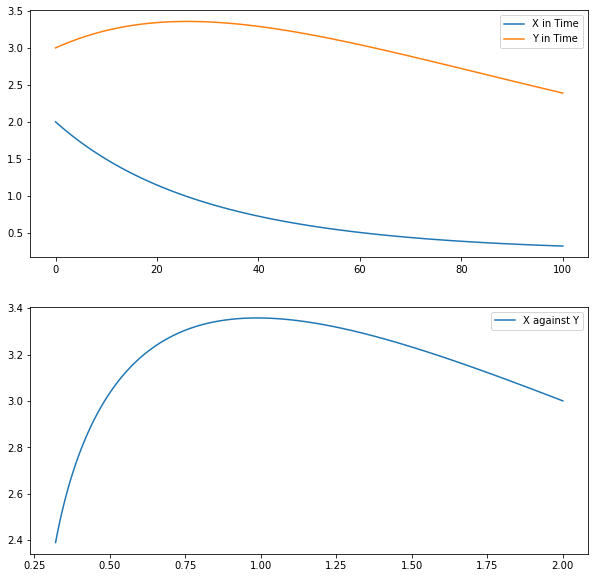

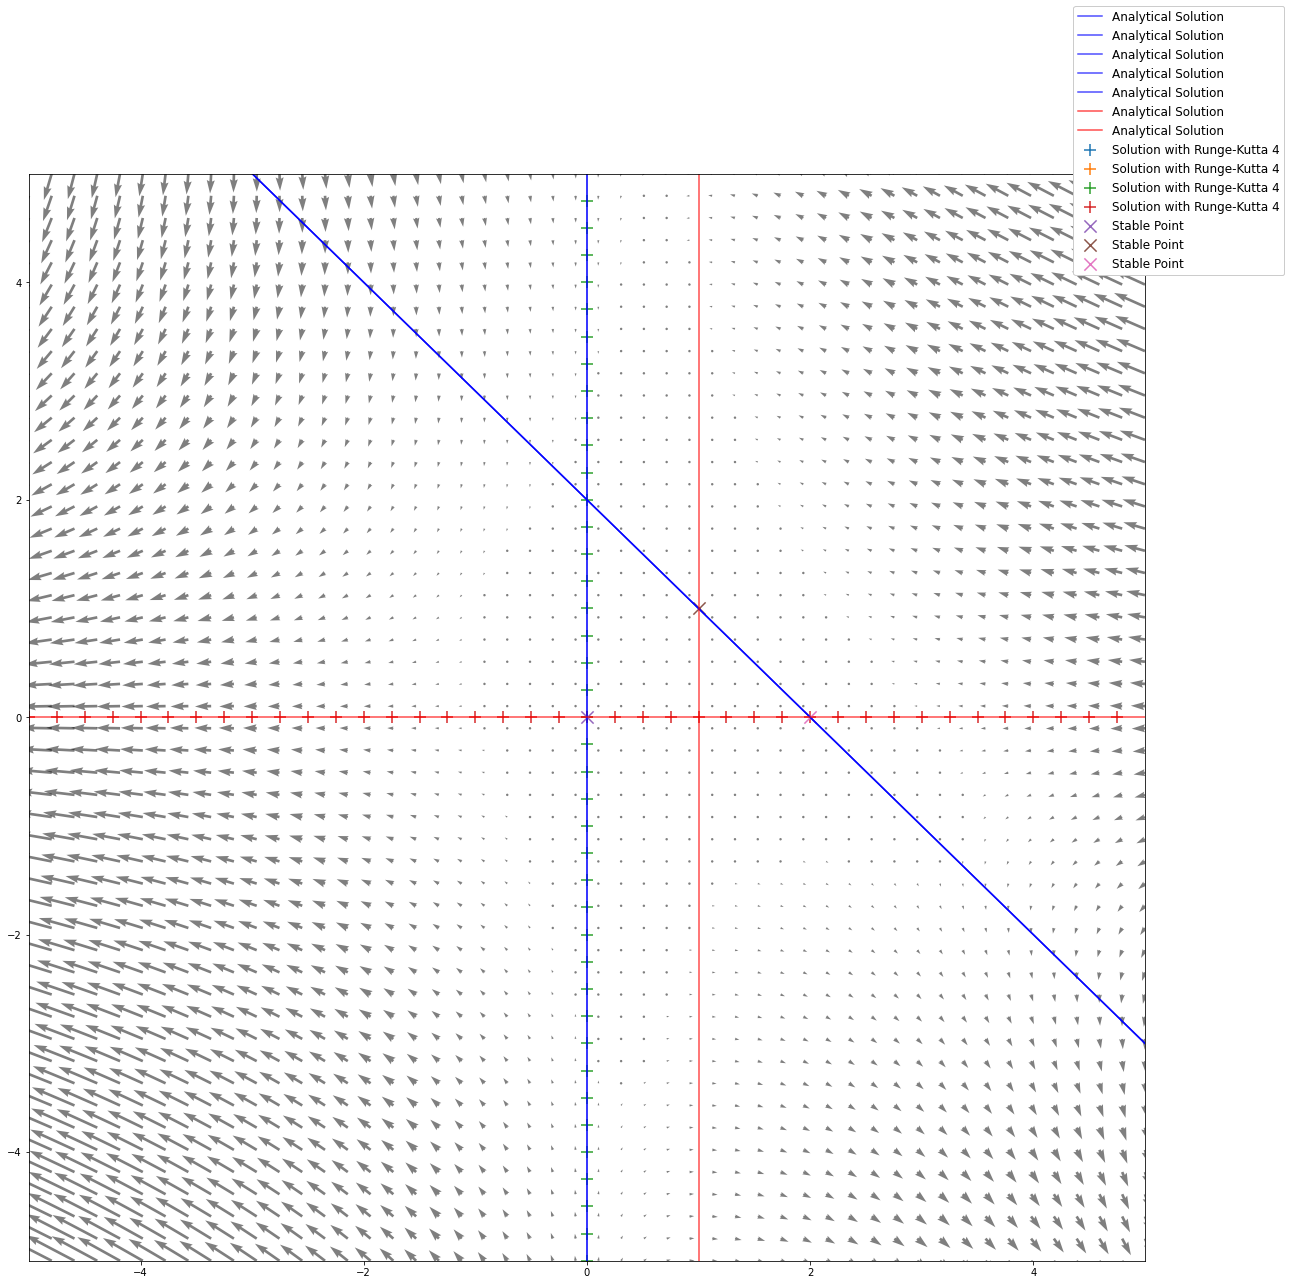

In [ ]:
y_range_slider = widgets.IntRangeSlider(min=-10, max=10)
display(y_range_slider)

x_range_slider = widgets.IntRangeSlider(min=-10, max=10)
display(x_range_slider)

startx = widgets.Text(placeholder='Start Value of X for RK4', disabled=False)
starty = widgets.Text(placeholder='Start Value of Y for RK4', disabled=False)
stepsize = widgets.Text(placeholder='Step Size for RK4', disabled=False)
stepcount = widgets.Text(placeholder='Step Count for RK4', disabled=False)

display(startx)
display(starty)
display(stepsize)
display(stepcount)

renderButton = widgets.Button(description='Plot')
display(renderButton)

@renderButton.on_click
def renderButtonOnClick(b):
    clear_output()
    
    display(y_range_slider)
    display(x_range_slider)
    display(renderButton)
    
    plots(expr1, expr2, x, y, int(startx.value), int(starty.value), float(stepsize.value), int(stepcount.value))